# Importing Needed Libraries

Just importing the standard things we will need

In [3]:
import numpy as np
from scipy.interpolate import griddata, RegularGridInterpolator
import matplotlib.pyplot as plt
import netCDF4 as nc4
from matplotlib.ticker import MaxNLocator
import xarray as xr



### Reading in and plotting bathymetry from MITgcm

Just sanity checkign that there is still bathymetry

Total number of elements in the file: 3600
(40, 90)


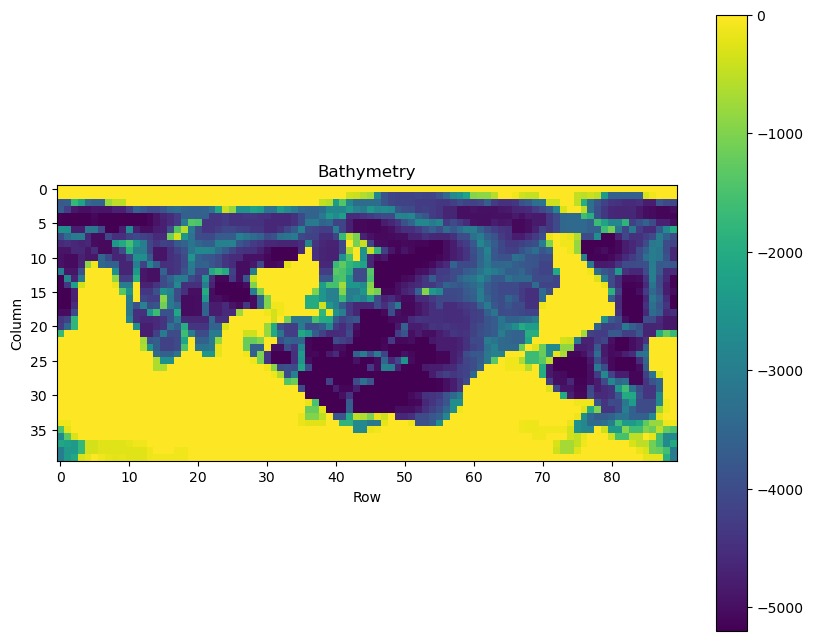

In [13]:
# read in the bathymetry grid
file_path = 'C:/Users/romed/Desktop/practicalcomputingtopics/cs185c_fall2025/MITgcm/verification/tutorial_global_oce_latlon/input/bathymetry.bin'
sNx = 45
sNy = 40
nSx =   2
nSy =   1
nPx =   1
nPy =   1
Nx  = sNx*nSx*nPx
Ny  = sNy*nSy*nPy

bathymetry = np.fromfile(file_path, '>f4').reshape((Ny, Nx))
print("Total number of elements in the file:", bathymetry.size)
print(np.shape(bathymetry))
# make a plot of the bathymetry
plt.figure(figsize=(10,8))
plt.imshow(bathymetry)
plt.colorbar() 
plt.title('Bathymetry')
plt.xlabel('Row')
plt.ylabel('Column')
plt.show()

# Rotate the bathymetry by 90°

Also store it to a file so we can use it later

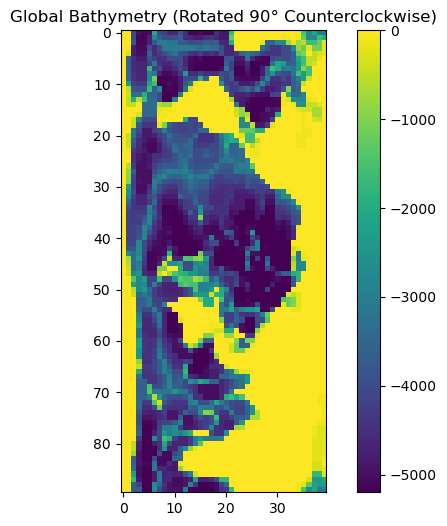

Rotated shape: (90, 40)
Min: -5200.0 Max: 0.0


In [54]:
# Rotate 90° counterclockwise
bathy_rotated = np.rot90(bathymetry)

plt.figure(figsize=(8, 6))
plt.imshow(bathy_rotated, cmap='viridis')
plt.title("Global Bathymetry (Rotated 90° Counterclockwise)")
plt.colorbar()
plt.show()

bathy_rotated.tofile("rotated_bathymetry.bin")

print("Rotated shape:", bathy_rotated.shape)
print("Min:", bathy_rotated.min(), "Max:", bathy_rotated.max())
bathy_rotated.astype(np.float32).tofile("rotated_bathymetry.bin")

# Sanity Check By Reloading the transformed file

We will load the file we saved before and ensure that the bathymetry is rotated properly

Read shape: (90, 40)
Min: -5200.0 Max: 0.0


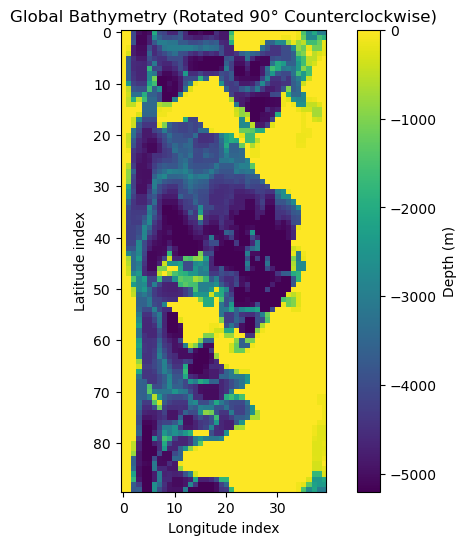

In [16]:
rotate_file_path = 'C:/Users/romed/Desktop/github fixer/cs185c_spring2025/Rotate_The_Earth/rotated_bathymetry.bin'


data = np.fromfile(rotate_file_path, dtype=np.float32)
data = data.reshape((Nx, Ny))
print("Read shape:", data.shape)
print("Min:", data.min(), "Max:", data.max())

# Plotting the data
plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='viridis')  # use origin='lower' if needed to orient correctly
plt.title("Global Bathymetry (Rotated 90° Counterclockwise)")
plt.xlabel("Longitude index")
plt.ylabel("Latitude index")
plt.colorbar(label="Depth (m)")
plt.show()



Double check shape: (240,) (130,)


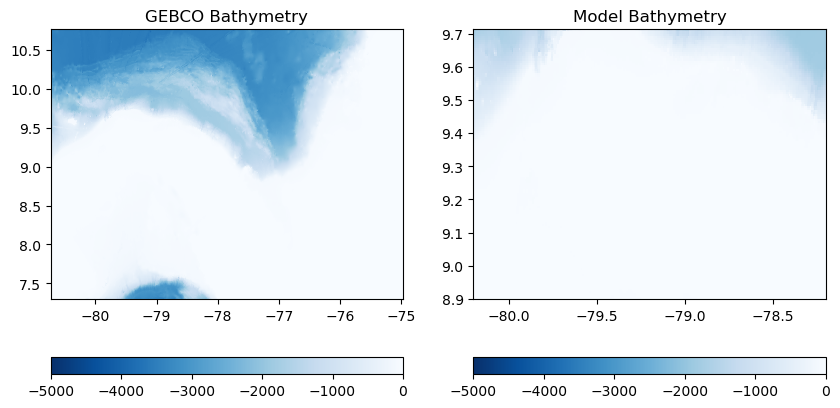

In [17]:
# read in the bathymetry grid
file_path = 'gebco_big_panama.nc'
ds = nc4.Dataset(file_path)
gebco_lon = ds.variables['lon'][:]
gebco_lat = ds.variables['lat'][:]
Gebco_bathy = ds.variables['elevation'][:]
ds.close()

# create a meshgrid of the lon and lat
Gebco_Lon, Gebco_Lat = np.meshgrid(gebco_lon, gebco_lat)

delX = 1/120
delY = 1/160
xgOrigin = -80.2
ygOrigin = 8.9
n_rows = 130
n_cols = 240

xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
XC, YC = np.meshgrid(xc, yc)
print('Double check shape:', np.shape(xc),np.shape(yc))

# interpolate the gebco data onto the model grid
Model_bathy = griddata(np.column_stack([Gebco_Lon.ravel(),Gebco_Lat.ravel()]), Gebco_bathy.ravel(), (XC, YC), method='nearest')

# set points on land to 0
Model_bathy[Model_bathy>0] = 0

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(Gebco_Lon, Gebco_Lat, Gebco_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('GEBCO Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, Model_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.show()

# An attempt using the full gebco dataset

I used the full gebco TID Dataset Im not fully sure if this is correct but this may just be a consequence of it being extra large.

<xarray.Dataset> Size: 7GB
Dimensions:    (lon: 86400, lat: 43200)
Coordinates:
  * lon        (lon) float64 691kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat        (lat) float64 346kB -90.0 -89.99 -89.99 ... 89.99 89.99 90.0
Data variables:
    crs        |S1 1B ...
    elevation  (lat, lon) int16 7GB ...
Attributes: (12/36)
    title:                           The GEBCO_2024 Grid - a continuous terra...
    summary:                         The GEBCO_2024 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/1c44ce99-0a0d-5f4f-e063-708...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/1c44ce99-0a0d-

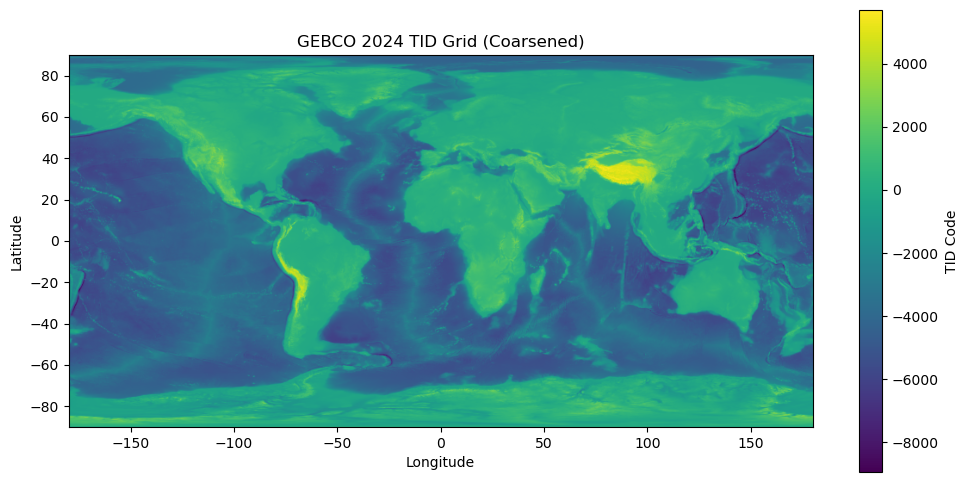

In [ ]:
ds = xr.open_dataset('GEBCO_2024_sub_ice_topo.nc')
print(ds)
print('---------------------------------------------')
ds2 = xr.open_dataset('GEBCO_2024_TID.nc')
print(ds2)

tid = ds.elevation
tid_coarse = tid.coarsen(lon=100, lat=100, boundary='trim').mean()


plt.figure(figsize=(12, 6))
plt.imshow(tid_coarse, cmap='viridis', extent=[-180, 180, -90, 90], origin='lower')
plt.title("GEBCO 2024 Bathymetry Grid (Coarsened)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Elevation")
plt.show()


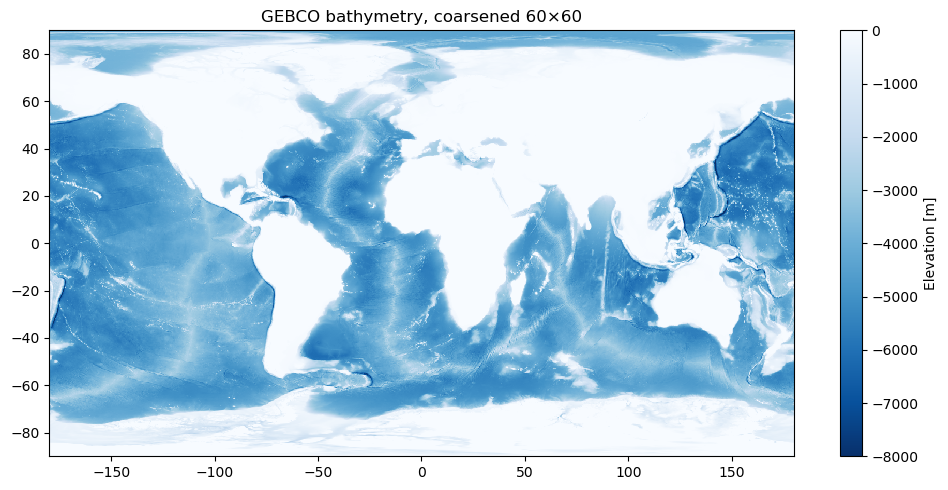

In [6]:
ds4 = xr.open_dataset(
        "GEBCO_2024_sub_ice_topo.nc",
        chunks={"lat": 4_000, "lon": 4_000}  
     )


F_LON, F_LAT = 60, 60    

ds_coarse = (
    ds4
    .coarsen(lon=F_LON, lat=F_LAT, boundary="trim")
    .mean()
    .compute()            
)


lon_c   = ds_coarse["lon"].values
lat_c   = ds_coarse["lat"].values
bathy_c = ds_coarse["elevation"].values


bathy_c = np.where(bathy_c > 0, 0, bathy_c)


plt.figure(figsize=(10, 5))
plt.pcolormesh(lon_c, lat_c, bathy_c,
               vmin=-8000, vmax=0, cmap="Blues_r", shading="auto")
plt.title(f"GEBCO bathymetry, coarsened {F_LAT}×{F_LON}")
plt.colorbar(label="Elevation [m]")
plt.tight_layout()
plt.show()

### Rotating Gebco by 90°
Finally we will attempt to rotate the gebco dataset by 90° and plot it, I am unsure if this is a properly usable bathymetry file however

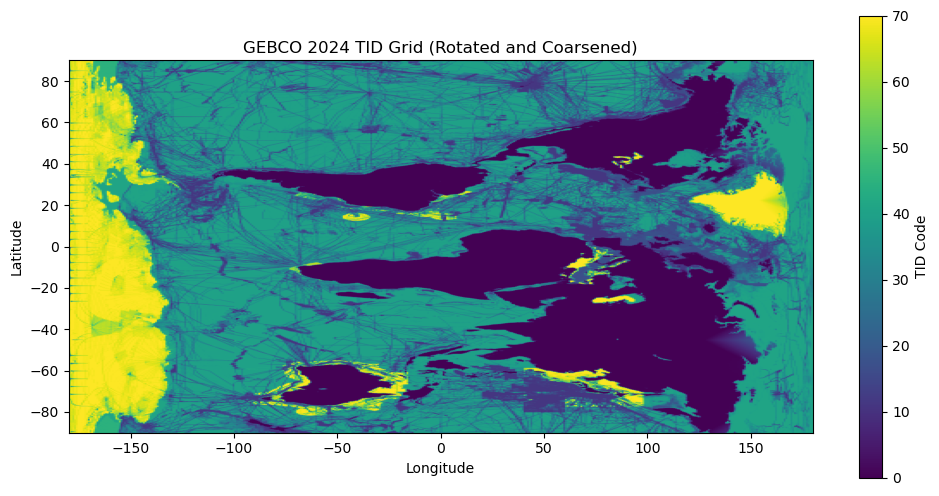

In [ ]:
tid_coarse_rotated = np.rot90(tid_coarse.values, k=1)

plt.figure(figsize=(12, 6))
plt.imshow(tid_coarse_rotated, cmap='viridis', extent=[-180, 180, -90, 90], origin='lower')
plt.title("GEBCO 2024 TID Grid (Rotated and Coarsened)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="TID Code")
plt.show()

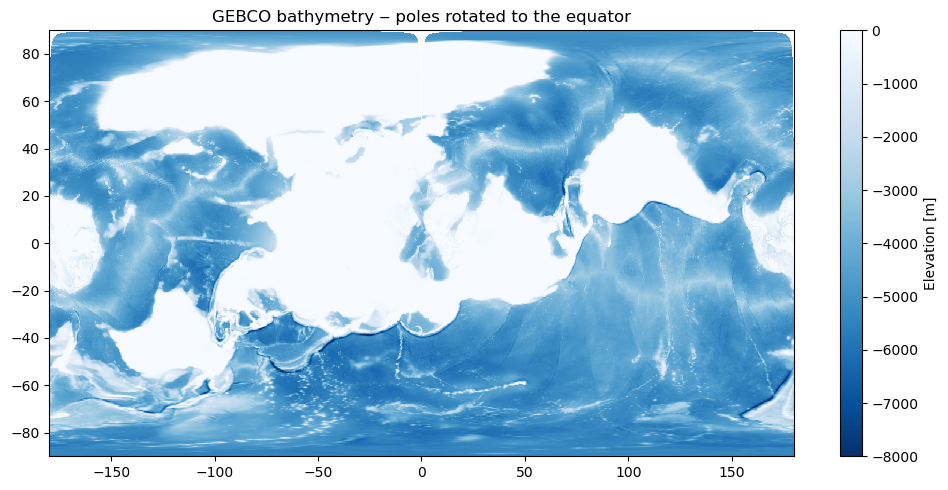

In [14]:
lat_orig = lat_c           
lon_orig = lon_c
elev_orig = bathy_c         


lon_orig_e = np.where(lon_orig < 0, lon_orig + 360, lon_orig)
sort_idx = np.argsort(lon_orig_e)
lon_orig_e = lon_orig_e[sort_idx]
elev_orig  = elev_orig[:, sort_idx]

interp = RegularGridInterpolator(
    (lat_orig, lon_orig_e),
    elev_orig,
    bounds_error=False,
    fill_value=np.nan,
)


LAT, LON = np.meshgrid(lat_orig, lon_orig_e, indexing="ij")


lat_r = np.deg2rad(LAT)
lon_r = np.deg2rad(LON)
x = np.cos(lat_r) * np.cos(lon_r)
y = np.cos(lat_r) * np.sin(lon_r)
z = np.sin(lat_r)
xp, yp, zp = z, y, -x

lat_src = np.rad2deg(np.arcsin(zp))
lon_src = np.rad2deg(np.arctan2(yp, xp))
lon_src = (lon_src + 360) % 360       
bathy_rot = interp(np.dstack((lat_src, lon_src)))


bathy_rot = np.where(bathy_rot > 0, 0, bathy_rot)


plt.figure(figsize=(10, 5))
plt.pcolormesh(lon_c, lat_c, bathy_rot,
               vmin=-8000, vmax=0, cmap="Blues_r", shading="auto")

plt.title("GEBCO bathymetry ‒ poles rotated to the equator")
plt.colorbar(label="Elevation [m]")
plt.tight_layout();  plt.show()

bathy_rot.astype(np.float32).tofile("rotated_global_bathymetry.bin")

### That seemed to have worked ok

Now to read in the file we saved to sanity check




Total number of elements in the file: 1036800
(720, 1440)


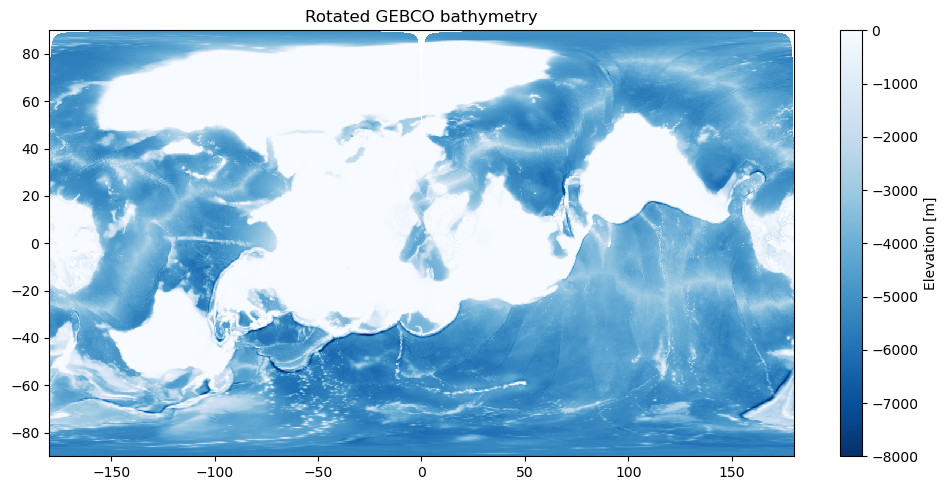

In [ ]:
rotate_file_path = 'C:/Users/romed/Desktop/github fixer/cs185c_spring2025/Rotate_The_Earth/rotated_global_bathymetry.bin'         
dtype = np.float32   
lon_c = lon_c
lat_c = lat_c
bathy_rot = np.fromfile(rotate_file_path, dtype=dtype)
print("Total number of elements in the file:", bathy_rot.size)
bathy_rot = bathy_rot.reshape(len(lat_c), len(lon_c))
print(np.shape(bathy_rot))

plt.figure(figsize=(10, 5))
plt.pcolormesh(lon_c, lat_c, bathy_rot,
               vmin=-8000, vmax=0, cmap="Blues_r", shading="auto")
plt.title("Rotated GEBCO bathymetry")
plt.colorbar(label="Elevation [m]")
plt.tight_layout()
plt.show()


Total number of elements in the file: 3600
(40, 90)


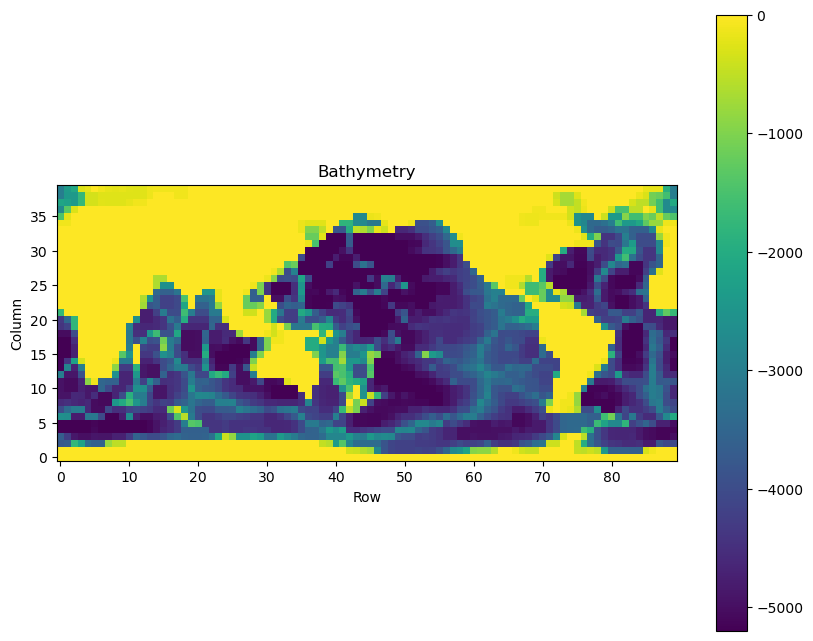

In [7]:
# read in the bathymetry grid
file_path = 'C:/Users/romed/Desktop/github fixer/cs185c_spring2025/Rotate_The_Earth/unrotatedbathymetry.bin'
sNx = 45
sNy = 40
nSx =   2
nSy =   1
nPx =   1
nPy =   1
Nx  = sNx*nSx*nPx
Ny  = sNy*nSy*nPy

bathymetry = np.fromfile(file_path, '>f4').reshape((Ny, Nx))
print("Total number of elements in the file:", bathymetry.size)
print(np.shape(bathymetry))
# make a plot of the bathymetry
plt.figure(figsize=(10,8))
plt.imshow(bathymetry, origin='lower')
plt.colorbar() 
plt.title('Bathymetry')
plt.xlabel('Row')
plt.ylabel('Column')
plt.show()

Total number of elements in the file: 3600
(40, 90)


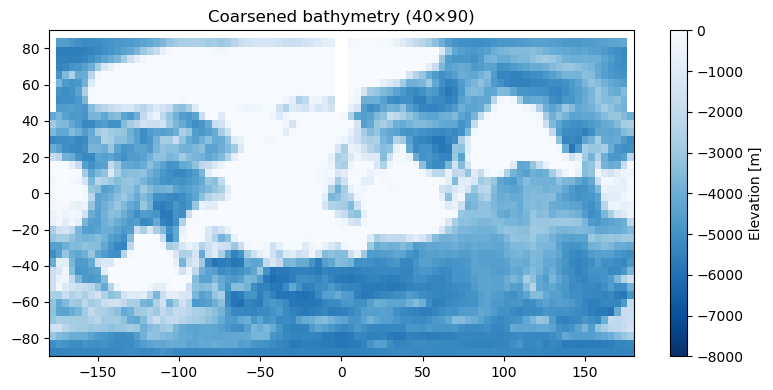

In [ ]:

new_nlat, new_nlon = 40, 90
lat_factor = bathy_rot.shape[0] // new_nlat   
lon_factor = bathy_rot.shape[1] // new_nlon   


bathy_coarse = bathy_rot.reshape(new_nlat, lat_factor,
                                 new_nlon, lon_factor) \
                        .mean(axis=(1,3))
print("Total number of elements in the file:", bathy_coarse.size)
print(bathy_coarse.shape) 

lat_coarse = np.mean(lat_c.reshape(new_nlat, lat_factor), axis=1)
lon_coarse = np.mean(lon_c.reshape(new_nlon, lon_factor), axis=1)


plt.figure(figsize=(8,4))
plt.pcolormesh(lon_coarse, lat_coarse, bathy_coarse,
               vmin=-8000, vmax=0, cmap="Blues_r", shading="auto")
plt.title("Coarsened bathymetry (40×90)")
plt.colorbar(label="Elevation [m]")
plt.tight_layout()
plt.show()

bathy_coarse.astype('>f4').tofile('coarsened_bathymetry.bin')

In [ ]:
file_path = 'C:/Users/romed/Desktop/github fixer/cs185c_spring2025/Rotate_The_Earth/coarsened_bathymetry.bin'
sNx = 45
sNy = 40
nSx =   2
nSy =   1
nPx =   1
nPy =   1
Nx  = sNx*nSx*nPx
Ny  = sNy*nSy*nPy

bathymetry = np.fromfile(file_path, '>f4').reshape((Ny, Nx))
print("Total number of elements in the file:", bathymetry.size)
print(np.shape(bathymetry))
# make a plot of the bathymetry
plt.figure(figsize=(10,8))
plt.imshow(bathymetry, origin='lower')
plt.colorbar() 
plt.title('Bathymetry')
plt.xlabel('Row')
plt.ylabel('Column')
plt.show()

ValueError: cannot reshape array of size 1800 into shape (40,90)